In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import tqdm
import timeit
import textwrap

from scipy import stats
from scipy.stats import zscore
from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.pipeline import make_pipeline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score

pd.options.mode.chained_assignment = None

In [2]:
path = 'C:/Users/delst/OneDrive - Queen Mary, University of London/Desktop/VSCode/Advanced_Projects/Uber_Demand_Project/data_archive/*.csv'
input_files = glob.glob(path)

In [3]:
def file_load(path):
        
    for i, file in enumerate(input_files):
        print(file)
        globals()[f'df{i+1}'] = pd.read_csv(input_files[i])
    print(f'Total number of files loaded: {len(input_files)}')
    
file_load(path)

C:/Users/delst/OneDrive - Queen Mary, University of London/Desktop/VSCode/Advanced_Projects/Uber_Demand_Project/data_archive\uber.csv
Total number of files loaded: 1


In [4]:
df_store = [eval(f'df{i+1}') for i in range(len(input_files))]   # Dataframe preperation

---

# **Initial Exploration**

In [5]:
keys_list = [df_store[i].keys() for i in range(len(df_store))]
flattened_list = [item for sublist in keys_list for item in sublist]
unique_keys = list(set(flattened_list))

print('Number of unique keys:', len(unique_keys))
# print(keys_list)
unique_keys

Number of unique keys: 9


['pickup_latitude',
 'dropoff_longitude',
 'Unnamed: 0',
 'passenger_count',
 'pickup_datetime',
 'key',
 'pickup_longitude',
 'dropoff_latitude',
 'fare_amount']

In [6]:
df = df_store[0]
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [7]:
df.describe().round()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.0,200000.0,200000.0,200000.0,199999.0,199999.0,200000.0
mean,27712504.0,11.0,-73.0,40.0,-73.0,40.0,2.0
std,16013822.0,10.0,11.0,8.0,13.0,7.0,1.0
min,1.0,-52.0,-1341.0,-74.0,-3357.0,-882.0,0.0
25%,13825346.0,6.0,-74.0,41.0,-74.0,41.0,1.0
50%,27745495.0,8.0,-74.0,41.0,-74.0,41.0,1.0
75%,41555301.0,12.0,-74.0,41.0,-74.0,41.0,2.0
max,55423567.0,499.0,57.0,1644.0,1154.0,873.0,208.0


In [8]:
# from sklearn.model_selection import StratifiedShuffleSplit

# X = df.drop('target_column', axis=1)
# y = df['target_column']

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# for train_index, test_index in sss.split(X, y):
#     df_sample = df.iloc[test_index]

In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 42.1 MB


In [10]:
memory_usage = df.memory_usage(deep=True)
print(memory_usage/1000000)

Index                 0.000128
Unnamed: 0            1.600000
key                  16.936069
fare_amount           1.600000
pickup_datetime      16.000000
pickup_longitude      1.600000
pickup_latitude       1.600000
dropoff_longitude     1.600000
dropoff_latitude      1.600000
passenger_count       1.600000
dtype: float64


In [11]:
df.isna().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [12]:
for col in df:
  print(df[col].unique())

[24238194 27835199 44984355 ... 27804658 20259894 11951496]
['2015-05-07 19:52:06.0000003' '2009-07-17 20:04:56.0000002'
 '2009-08-24 21:45:00.00000061' ... '2009-06-29 00:42:00.00000078'
 '2015-05-20 14:56:25.0000004' '2010-05-15 04:08:00.00000076']
[ 7.5   7.7  12.9  ... 37.2  86.25 89.1 ]
['2015-05-07 19:52:06 UTC' '2009-07-17 20:04:56 UTC'
 '2009-08-24 21:45:00 UTC' ... '2009-06-29 00:42:00 UTC'
 '2015-05-20 14:56:25 UTC' '2010-05-15 04:08:00 UTC']
[-73.99981689 -73.994355   -74.005043   ... -73.969204   -74.003548
 -73.99712372]
[40.73835373 40.728225   40.74077    ... 40.74391937 40.72121
 40.72545242]
[-73.99951172 -73.99471    -73.962565   ... -73.95223999 -74.01390839
 -73.858957  ]
[40.72321701 40.750325   40.772647   ... 40.692588   40.6954155
 40.768793  ]
[  1   3   5   2   4   6   0 208]


In [13]:
count = df['passenger_count'].eq(208).sum()
count

1

In [14]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [15]:
df = df[['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime','passenger_count']]
df

,Unnamed: 0,key,fare_amount,pickup_datetime,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,5
...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,1


---

# **Data Cleaning and Feature Engineering**

- Initial feature engineering will take place allowing us to later engineer our target variable
- Data cleaning will take place, including handling of NaNs and outlier removal
- Final feature engineering will take place, with the creation of our target variable PED

In [16]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_localize(None)
print((df.pickup_datetime.dtype))

datetime64[ns]


In [17]:
df['Label_Hour'] = df['pickup_datetime'].dt.hour
df['Label_Date'] = df['pickup_datetime'].dt.date
df['pickup_datetime'] = df['pickup_datetime'].dt.floor('H')
df['day_name'] = pd.to_datetime(df['pickup_datetime']).dt.day_name()
df['day_of_the_week'] = pd.to_datetime(df['pickup_datetime']).dt.weekday

In [18]:
df = df[(np.abs(stats.zscore(df['passenger_count'])) < 2)]
df = df[(np.abs(stats.zscore(df['fare_amount'])) < 2)]
df

,Unnamed: 0,key,fare_amount,pickup_datetime,passenger_count,Label_Hour,Label_Date,day_name,day_of_the_week
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:00:00,1,19,2015-05-07,Thursday,3
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:00:00,1,20,2009-07-17,Friday,4
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:00:00,1,21,2009-08-24,Monday,0
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:00:00,3,8,2009-06-26,Friday,4
5,44470845,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:00:00,1,2,2011-02-12,Saturday,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:00:00,1,10,2012-10-28,Sunday,6
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:00:00,1,1,2014-03-14,Friday,4
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:00:00,2,0,2009-06-29,Monday,0
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:00:00,1,14,2015-05-20,Wednesday,2


In [19]:
select_cols = ['pickup_datetime', 'fare_amount', 'passenger_count','Label_Date']
# Group the demand and price data by day using the pickup_datetime column to extract the date, and then use the pandas groupby() function to group the data by date.
dfh = df[select_cols].groupby('pickup_datetime').agg({'passenger_count':'mean','fare_amount':'mean'}).reset_index()
dfd = df[select_cols].groupby(['Label_Date'])['passenger_count','fare_amount'].agg({'passenger_count':'mean','fare_amount':'mean'}).reset_index()

display(dfh.describe(), dfd.describe())

C:\Users\delst\AppData\Local\Temp/ipykernel_9856/3314034989.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfd = df[select_cols].groupby(['Label_Date'])['passenger_count','fare_amount'].agg({'passenger_count':'mean','fare_amount':'mean'}).reset_index()


,passenger_count,fare_amount
count,49642.000000,49642.000000
mean,1.318290,9.714609
std,0.443541,3.744842
min,0.000000,-3.000000
25%,1.000000,7.220000
50%,1.166667,9.000000
75%,1.500000,11.416667
max,4.000000,31.100000


,passenger_count,fare_amount
count,2372.000000,2372.000000
mean,1.325536,9.646610
std,0.107412,0.984512
min,1.000000,6.732727
25%,1.250000,8.907859
50%,1.312500,9.558655
75%,1.388889,10.363672
max,1.795918,12.971864


In [20]:
dfh

,pickup_datetime,passenger_count,fare_amount
0,2009-01-01 01:00:00,2.00,10.750000
1,2009-01-01 02:00:00,1.80,8.980000
2,2009-01-01 03:00:00,4.00,17.800000
3,2009-01-01 04:00:00,1.25,9.800000
4,2009-01-01 05:00:00,1.00,14.200000
...,...,...,...
49637,2015-06-30 19:00:00,1.00,11.166667
49638,2015-06-30 20:00:00,2.50,6.875000
49639,2015-06-30 21:00:00,2.00,10.500000
49640,2015-06-30 22:00:00,1.25,9.500000


In [21]:
dfh['fare_amount'] = abs(dfh.fare_amount)
dfh.passenger_count.replace(0, 1, inplace=True)
dfh.fare_amount.replace(0, 1, inplace=True)

In [22]:
cols = ['passenger_count', 'fare_amount']

for col in cols:
    dfh[col + '_pct_change'] = dfh[col].pct_change()
    
for col in cols:
    dfd[col + '_pct_change'] = dfd[col].pct_change()

In [23]:
n_hour = 3
dfh['pc_pct_change_sma_hour'] = dfh['passenger_count_pct_change'].rolling(window=n_hour).mean()
dfh['fa_pct_change_sma_hour'] = dfh['fare_amount_pct_change'].rolling(window=n_hour).mean()

n_day = 24
dfh['pc_pct_change_sma_day'] = dfh['passenger_count_pct_change'].rolling(window=n_day).mean()
dfh['fa_pct_change_sma_day'] = dfh['fare_amount_pct_change'].rolling(window=n_day).mean()

n_week = 7
dfd['pc_pct_change_sma_week'] = dfd['passenger_count_pct_change'].rolling(window=n_week).mean()
dfd['fa_pct_change_sma_week'] = dfd['fare_amount_pct_change'].rolling(window=n_week).mean()

In [24]:
dfh['PED_hour'] = (dfh.pc_pct_change_sma_hour / dfh.fa_pct_change_sma_hour)
dfh['PED_day'] = (dfh.pc_pct_change_sma_day / dfh.fa_pct_change_sma_day)
dfd['PED_week'] = (dfd.pc_pct_change_sma_week / dfd.fa_pct_change_sma_week)

In [25]:
dfh.describe()

,passenger_count,fare_amount,passenger_count_pct_change,fare_amount_pct_change,pc_pct_change_sma_hour,fa_pct_change_sma_hour,pc_pct_change_sma_day,fa_pct_change_sma_day,PED_hour,PED_day
count,49642.000000,49642.000000,49641.000000,49641.000000,49639.000000,49639.000000,49618.000000,49618.000000,4.963900e+04,49618.000000
mean,1.318934,9.714750,0.079233,0.131509,0.079224,0.131495,0.079211,0.131496,-1.512117e+10,0.751983
std,0.442350,3.744479,0.447803,0.621391,0.170583,0.250725,0.041558,0.065216,3.368969e+12,5.944648
min,0.333333,1.000000,-0.875000,-0.907407,-0.369444,-0.483204,-0.017956,-0.015217,-7.505999e+14,-1300.807512
25%,1.000000,7.220000,-0.200000,-0.265487,-0.025000,-0.026249,0.049577,0.085948,-5.026669e-01,0.370879
50%,1.166667,9.000000,0.000000,0.000000,0.055556,0.088636,0.072530,0.119552,9.677419e-02,0.600524
75%,1.500000,11.416667,0.250000,0.364389,0.166667,0.233804,0.101280,0.164220,8.960841e-01,0.954804
max,4.000000,31.100000,5.000000,11.200000,1.750000,3.555230,0.353987,0.586184,5.841481e+03,102.236241


In [26]:
def replace_outliers(col, threshold):
    
    median = col.median()
    
    lower_quantile = col.quantile(threshold)
    upper_quantile = col.quantile(1-threshold)
    
    col[col < lower_quantile] = -1*median
    col[col > upper_quantile] = median
    
    return col

dfh['PED_hour'] = replace_outliers(dfh.PED_hour, 0.05)
dfh['PED_day'] = replace_outliers(dfh.PED_day, 0.05)
dfd['PED_week'] = replace_outliers(dfd.PED_week, 0.05)

In [27]:
dfh

,pickup_datetime,passenger_count,fare_amount,passenger_count_pct_change,fare_amount_pct_change,pc_pct_change_sma_hour,fa_pct_change_sma_hour,pc_pct_change_sma_day,fa_pct_change_sma_day,PED_hour,PED_day
0,2009-01-01 01:00:00,2.00,10.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01 02:00:00,1.80,8.980000,-0.100000,-0.164651,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01 03:00:00,4.00,17.800000,1.222222,0.982183,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01 04:00:00,1.25,9.800000,-0.687500,-0.449438,1.449074e-01,0.122698,NaN,NaN,1.181011e+00,NaN
4,2009-01-01 05:00:00,1.00,14.200000,-0.200000,0.448980,1.115741e-01,0.327241,NaN,NaN,3.409535e-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...
49637,2015-06-30 19:00:00,1.00,11.166667,0.000000,-0.059649,4.440892e-15,0.127385,0.057978,0.234172,3.486192e-14,0.247589
49638,2015-06-30 20:00:00,2.50,6.875000,1.500000,-0.384328,5.000000e-01,-0.225949,0.113782,0.205602,-2.212884e+00,0.553411
49639,2015-06-30 21:00:00,2.00,10.500000,-0.200000,0.527273,4.333333e-01,0.027765,0.095833,0.235466,9.677419e-02,0.406994
49640,2015-06-30 22:00:00,1.25,9.500000,-0.375000,-0.095238,3.083333e-01,0.015902,0.090625,0.229874,9.677419e-02,0.394237


---

In [28]:
dfh['Label_Date'] = dfh['pickup_datetime'].dt.date
ped_hour = dfh[['pickup_datetime','PED_hour']]
ped_day = dfh[['Label_Date','PED_day']].groupby('Label_Date').agg({'PED_day':'mean'}).reset_index()
ped_week = dfd[['Label_Date','PED_week']].groupby(['Label_Date']).agg({'PED_week':'mean'}).reset_index()

<AxesSubplot:>

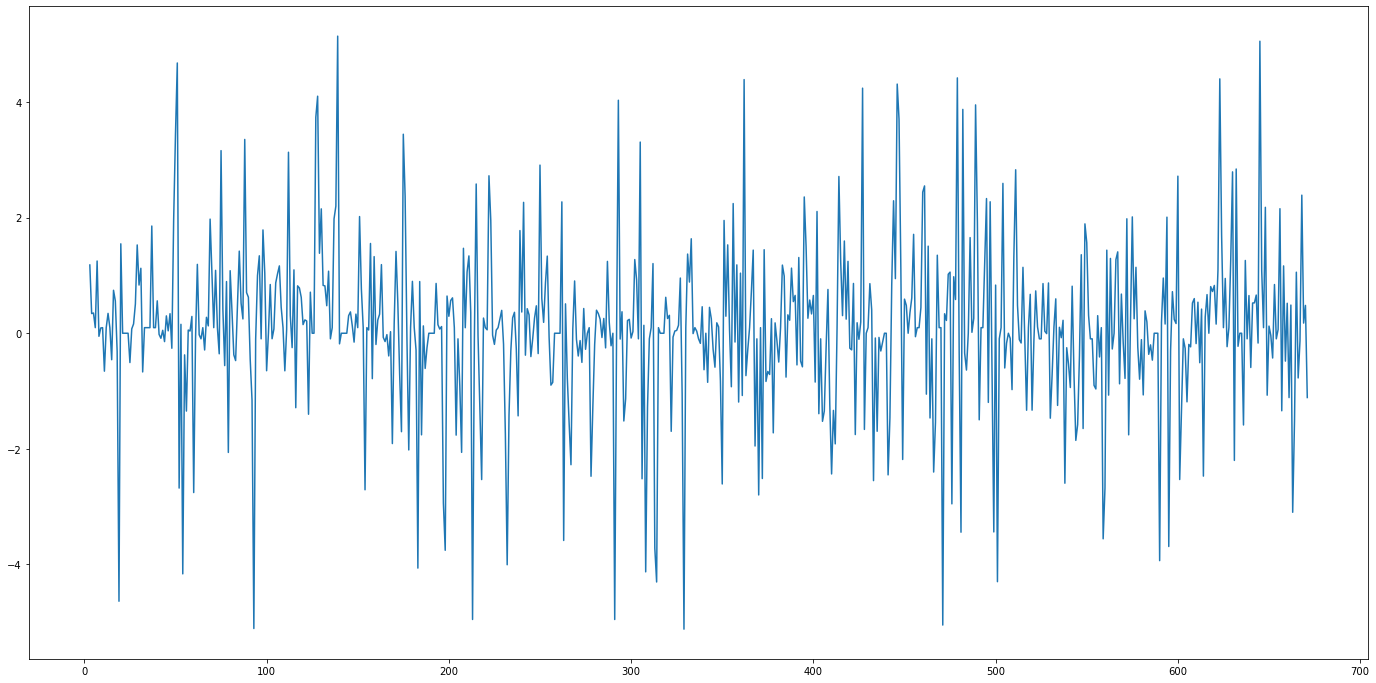

In [29]:
ped_hour[0:24*7*4].PED_hour.plot(figsize=(24,12))

<AxesSubplot:>

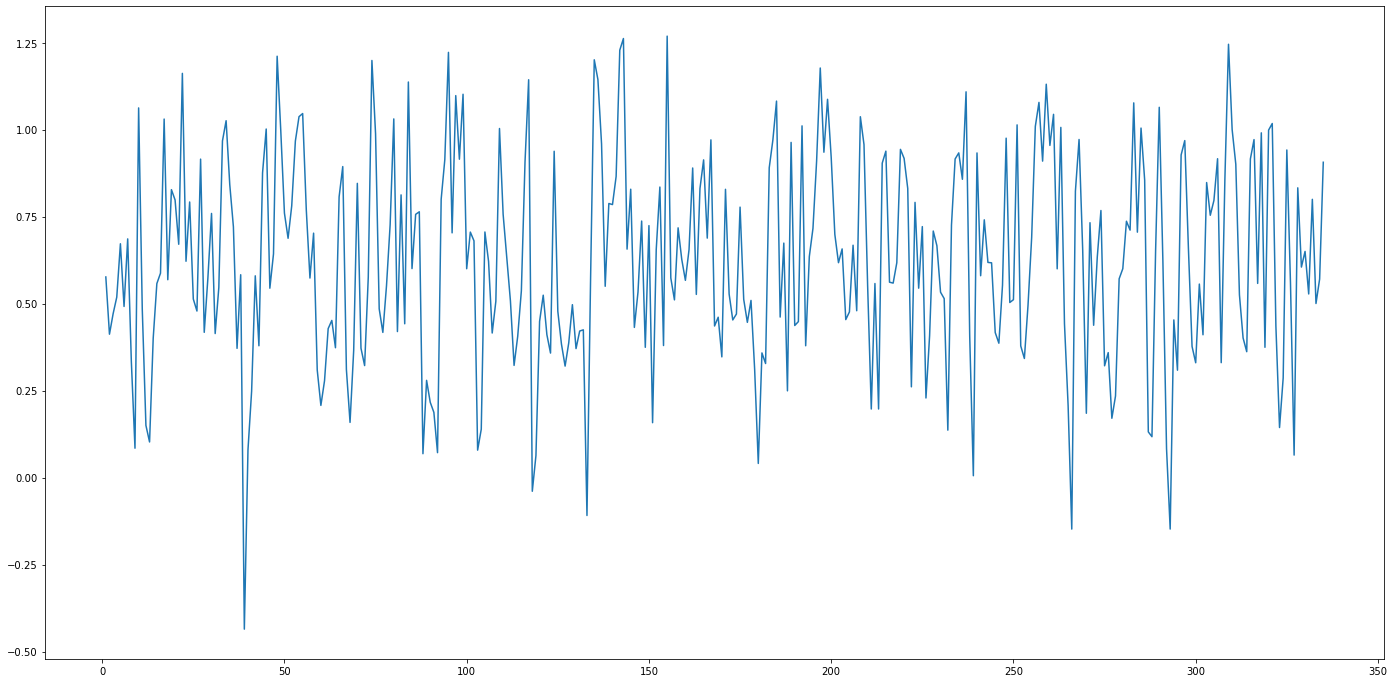

In [30]:
ped_day[0:28*12].PED_day.plot(figsize=(24,12))

<AxesSubplot:>

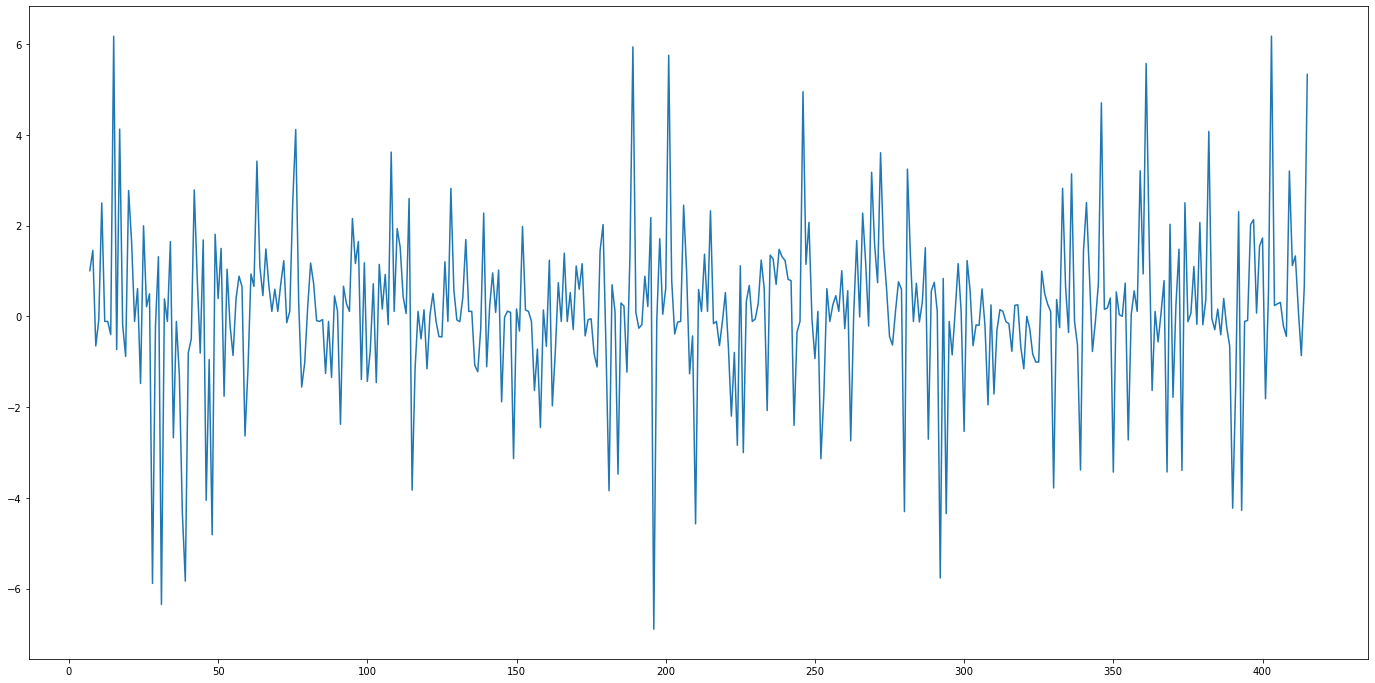

In [31]:
ped_week[0:52*8].PED_week.plot(figsize=(24,12))

---

In [32]:
dfh.isna().sum()
dfh = dfh.dropna()

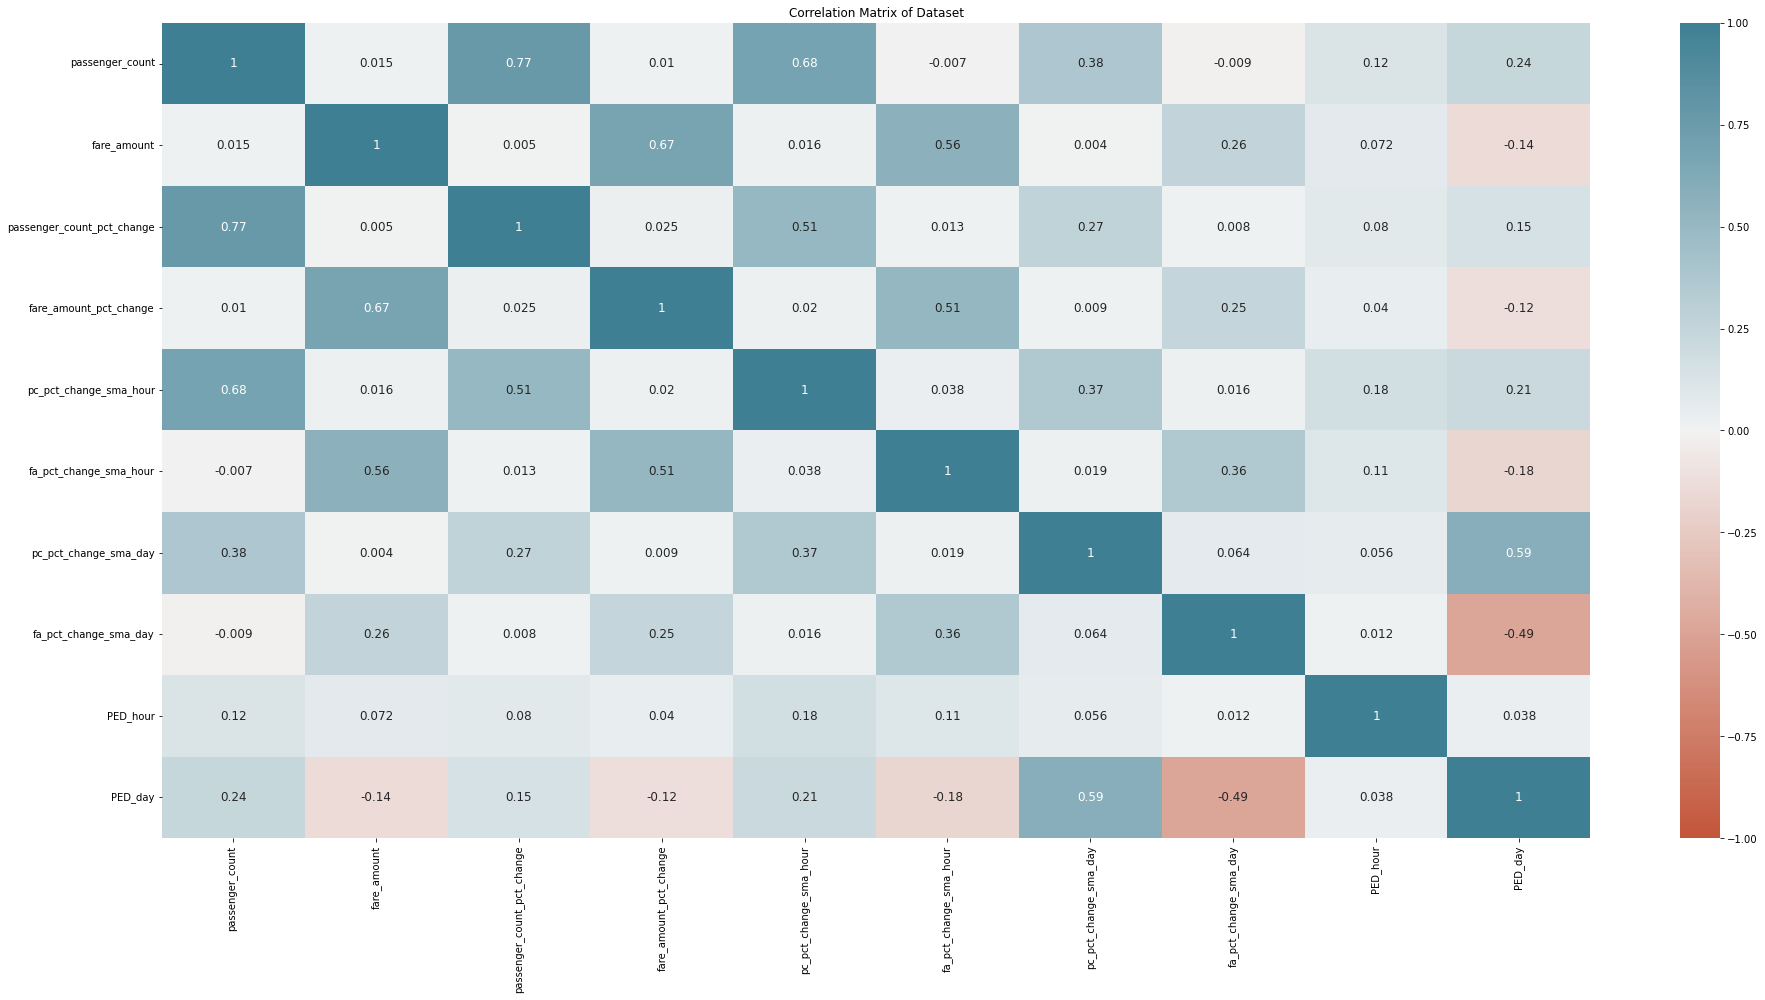

In [33]:
# Correlation Matrix
fig,ax = plt.subplots(1,1, figsize=(32,15))

sns.heatmap(dfh.corr().round(3), vmin=-1, vmax=1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 12})

_y = plt.yticks(rotation=0, fontsize=10)
_x = plt.xticks(rotation=90, fontsize=10)

plt.title('Correlation Matrix of Dataset')
plt.show()

---

In [34]:
n = 24*7*4*12
dfh = dfh[0:n].set_index('pickup_datetime')
dfh.index = dfh.index.strftime("%Y-%m-%d-%H")
dfh

,passenger_count,fare_amount,passenger_count_pct_change,fare_amount_pct_change,pc_pct_change_sma_hour,fa_pct_change_sma_hour,pc_pct_change_sma_day,fa_pct_change_sma_day,PED_hour,PED_day,Label_Date
pickup_datetime,,,,,,,,,,,
2009-01-02-10,1.000000,14.100000,0.000000,-0.090323,0.000000,0.255509,0.068056,0.121057,0.000000,0.562178,2009-01-02
2009-01-02-11,1.333333,6.633333,0.333333,-0.529551,0.111111,-0.219047,0.086111,0.105853,-0.507248,0.813499,2009-01-02
2009-01-02-12,1.000000,18.037500,-0.250000,1.719221,0.027778,0.366449,0.024769,0.136563,0.075803,0.181371,2009-01-02
2009-01-02-13,1.000000,5.940000,0.000000,-0.670686,0.027778,0.172995,0.053414,0.127344,0.160570,0.419449,2009-01-02
2009-01-02-15,2.000000,8.500000,1.000000,0.430976,0.250000,0.493170,0.103414,0.126594,0.506924,0.816899,2009-01-02
...,...,...,...,...,...,...,...,...,...,...,...
2010-01-21-08,1.000000,7.233333,-0.571429,-0.026906,0.087302,-0.285403,0.097047,0.160199,-0.305889,0.605788,2010-01-21
2010-01-21-09,1.000000,9.300000,0.000000,0.285714,0.253968,-0.054988,0.097047,0.196448,-4.618608,0.494006,2010-01-21
2010-01-21-10,1.500000,5.100000,0.500000,-0.451613,-0.023810,-0.064268,0.117880,0.133337,0.370472,0.884076,2010-01-21


In [35]:
# input_features = dfh['passenger_count', 'fare_amount',
#        'passenger_count_pct_change', 'fare_amount_pct_change',
#        'pc_pct_change_sma_hour', 'fa_pct_change_sma_hour',
#        'pc_pct_change_sma_day', 'fa_pct_change_sma_day']

In [36]:
input_features = dfh.drop(['PED_hour', 'Label_Date'], axis=1)
target_variable = dfh['PED_hour']

X_train, X_test, y_train, y_test = train_test_split(input_features, target_variable, shuffle=False, test_size=0.1)

In [37]:
dtr = DecisionTreeRegressor(random_state=0)
lr = LinearRegression()
rfr = RandomForestRegressor()
svr = SVR(C=1.0, epsilon=0.2)
xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=5, eta=0.1, subsample=0.9)

model = dtr, lr, rfr, svr, xgb

In [38]:
def try_initial_models(model, X_train, X_test, y_train, y_test):
    results = []
    n_splits = 5

    for i in range(len(model)):
        std_clf = make_pipeline(StandardScaler(), model[i])
        
        r2_scores = []
        mae_scores = []
        rmse_scores = []
        
        kf = KFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
            
            std_clf.fit(X_train_cv, y_train_cv)
            y_pred = std_clf.predict(X_test_cv)
            
            r2_scores.append(r2_score(y_test_cv, y_pred))
            mae_scores.append(mean_absolute_error(y_test_cv, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_test_cv, y_pred)))
            
        print(model[i])
        print("Mean R^2 : ", sum(r2_scores) / n_splits)
        print("Mean MAE :", sum(mae_scores) / n_splits)
        print("Mean RMSE:", sum(rmse_scores) / n_splits)
        print('-------------------------------------')

        results.append(y_pred)
        
    return results

y_pred_model_vals = try_initial_models(model, X_train, X_test, y_train, y_test)

DecisionTreeRegressor(random_state=0)
Mean R^2 :  0.7734874141759949
Mean MAE : 0.1909175524741765
Mean RMSE: 0.6751100337566787
-------------------------------------
LinearRegression()
Mean R^2 :  0.04153582190369063
Mean MAE : 0.8915702008637613
Mean RMSE: 1.3992955914551115
-------------------------------------
RandomForestRegressor()
Mean R^2 :  0.8840389293689581
Mean MAE : 0.16260895288983193
Mean RMSE: 0.4863847068648733
-------------------------------------
SVR(epsilon=0.2)
Mean R^2 :  0.3055187821694781
Mean MAE : 0.6659196358588346
Mean RMSE: 1.1912282677295039
-------------------------------------
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100

In [43]:
y_pred_model_vals

[array([ 0.52364481, -0.6487039 ,  0.09677419, ...,  0.1798742 ,
        -2.60693846,  3.64688968]),
 array([-0.14103631, -0.21343135, -0.46118435, ...,  0.42744456,
        -0.26222047, -0.05215142]),
 array([ 0.18385893,  0.09677419, -0.03632256, ...,  0.5246241 ,
        -0.19434938, -2.67547154]),
 array([ 0.03408875, -1.29413011,  0.5670804 , ...,  0.78876692,
        -0.26596496, -0.51408176]),
 array([ 0.10029049,  0.09142217,  0.06221942, ...,  0.6605582 ,
         1.670891  , -2.0497658 ], dtype=float32)]

In [39]:
# std_clf = make_pipeline(StandardScaler(), RandomForestRegressor())

# std_clf.fit(X_train, y_train)
# y_pred = std_clf.predict(X_test_cv)

std_clf = make_pipeline(StandardScaler(), RandomForestRegressor())

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_train = cross_val_predict(std_clf, X_train, y_train, cv=kfold)
y_pred = cross_val_predict(std_clf, X_test, y_test, cv=kfold)

In [ ]:
def initial_model
    std_clf = make_pipeline(StandardScaler(), model[i])

    kf = KFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
        
        std_clf.fit(X_train_cv, y_train_cv)
        y_pred = std_clf.predict(X_test_cv)

In [ ]:
def train_model(X_train, y_train, model):
    std_clf = make_pipeline(StandardScaler(), model)
    
    kf = KFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
        
        std_clf.fit(X_train_cv, y_train_cv)
        
    return std_clf

def validate_model(X_train, y_train, std_clf):
    y_pred_train = cross_val_predict(std_clf, X_train, y_train, cv=kf)
    return y_pred_train

def test_model(X_test, y_test, std_clf):
    y_pred = std_clf.predict(X_test)
    return y_pred

std_clf = train_model(X_train, y_train, model)
y_pred_train = validate_model(X_train, y_train, std_clf)
y_pred = test_model(X_test, y_test, std_clf)

In [40]:
# n=24*7*4
# fig, ax = plt.subplots(1, 1, figsize=(32, 10))
# plt.plot(y_test[0:n])
# plt.plot(y_pred[0:n],color='r',linewidth=2, alpha=0.5, linestyle='--')
# plt.title("Initial Model (red) Predicting Price Elasticity of Demand (PED)")
# plt.show()

In [41]:
# n=24*7*4
# fig, ax = plt.subplots(1, 1, figsize=(32, 10))
# plt.plot(y_test[0:n])
# plt.plot(y_pred[0:n],color='r',linewidth=2, alpha=0.5, linestyle='--')
# plt.title("Initial Model (red) Predicting Price Elasticity of Demand (PED)")
# plt.show()

NameError: name 'Y' is not defined

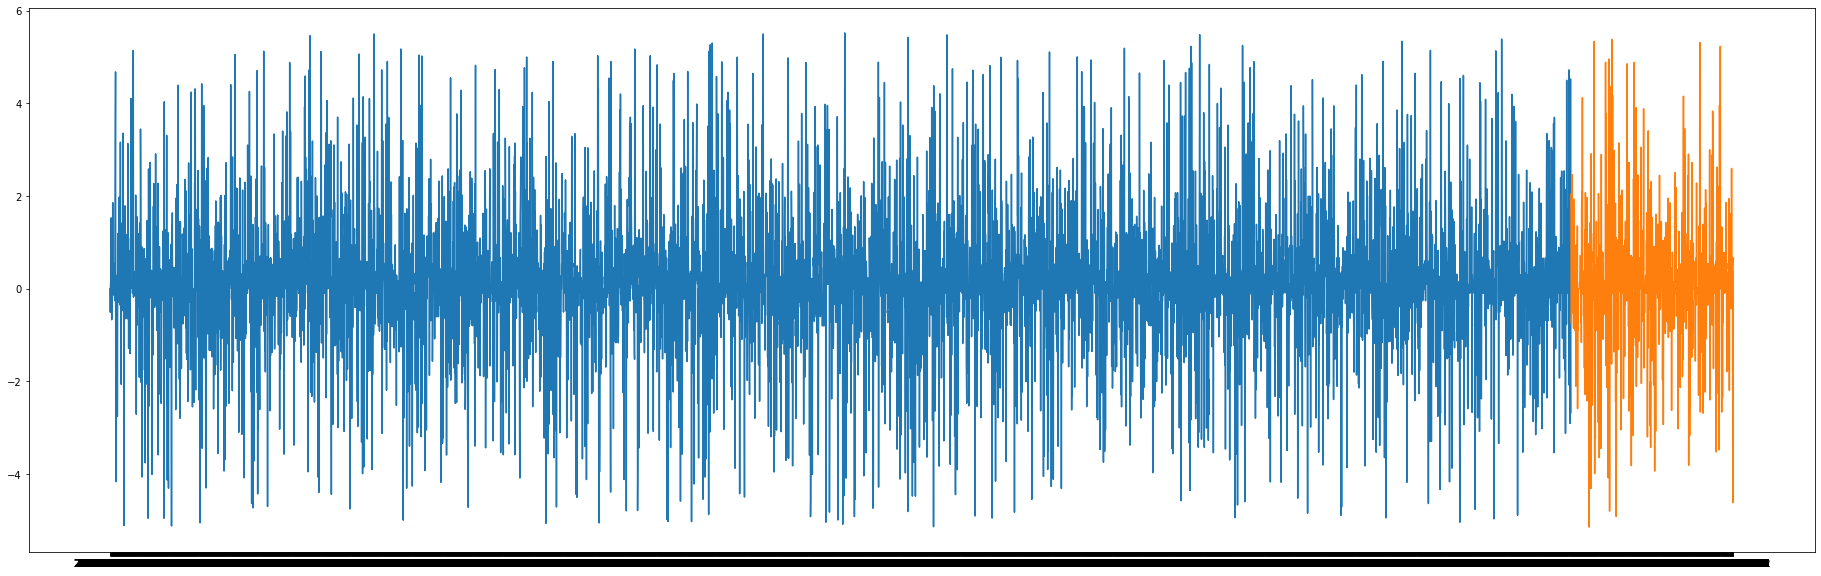

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(32, 10))

plt.plot(y_train.index.sort_values(), y_train)
plt.plot(y_test.index.sort_values(), y_test)
plt.xticks(Y.index[::145],  rotation='vertical')

plt.show()

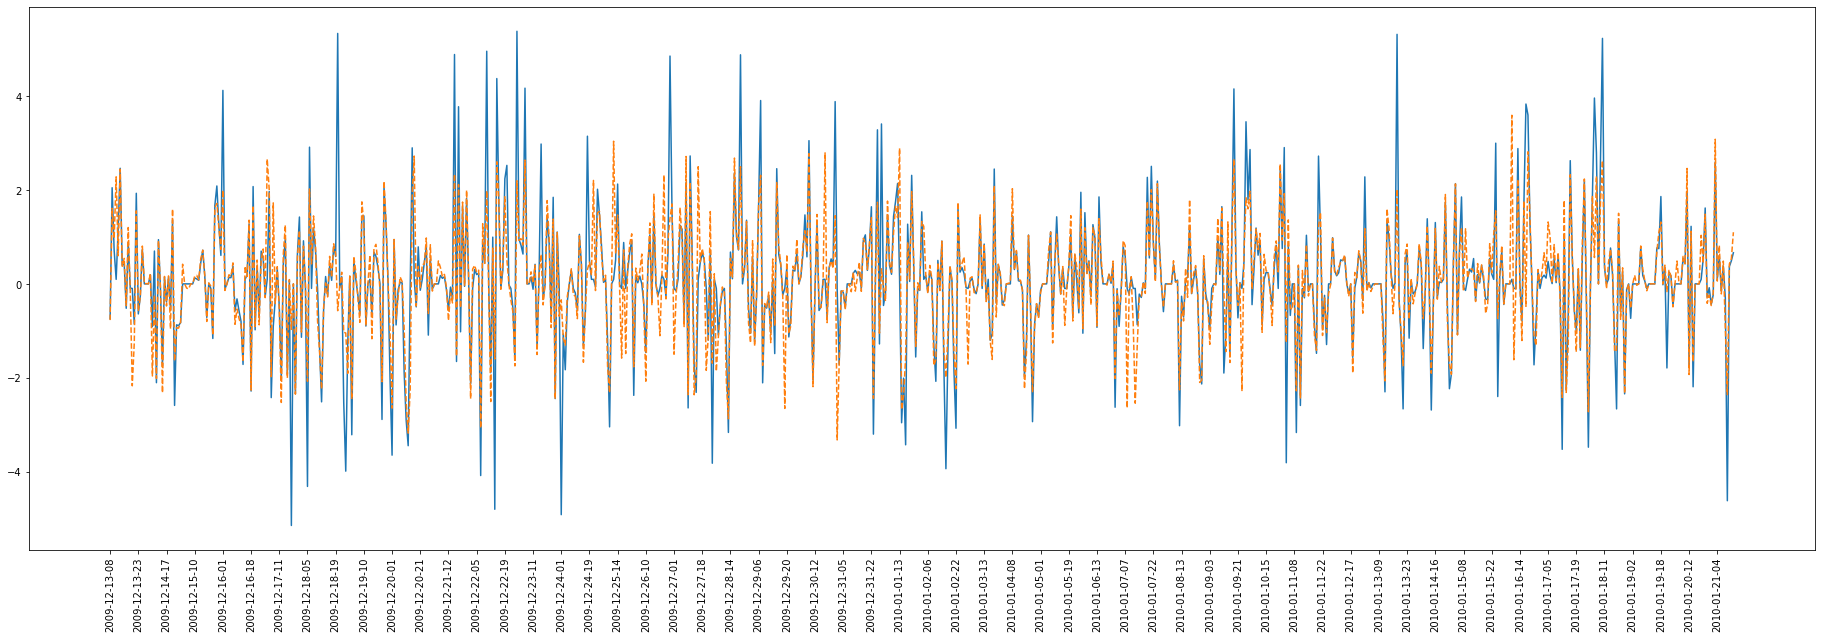

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(32, 10))

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_pred, linestyle='--')
plt.xticks(y_test.index[::14],  rotation='vertical')

plt.show()

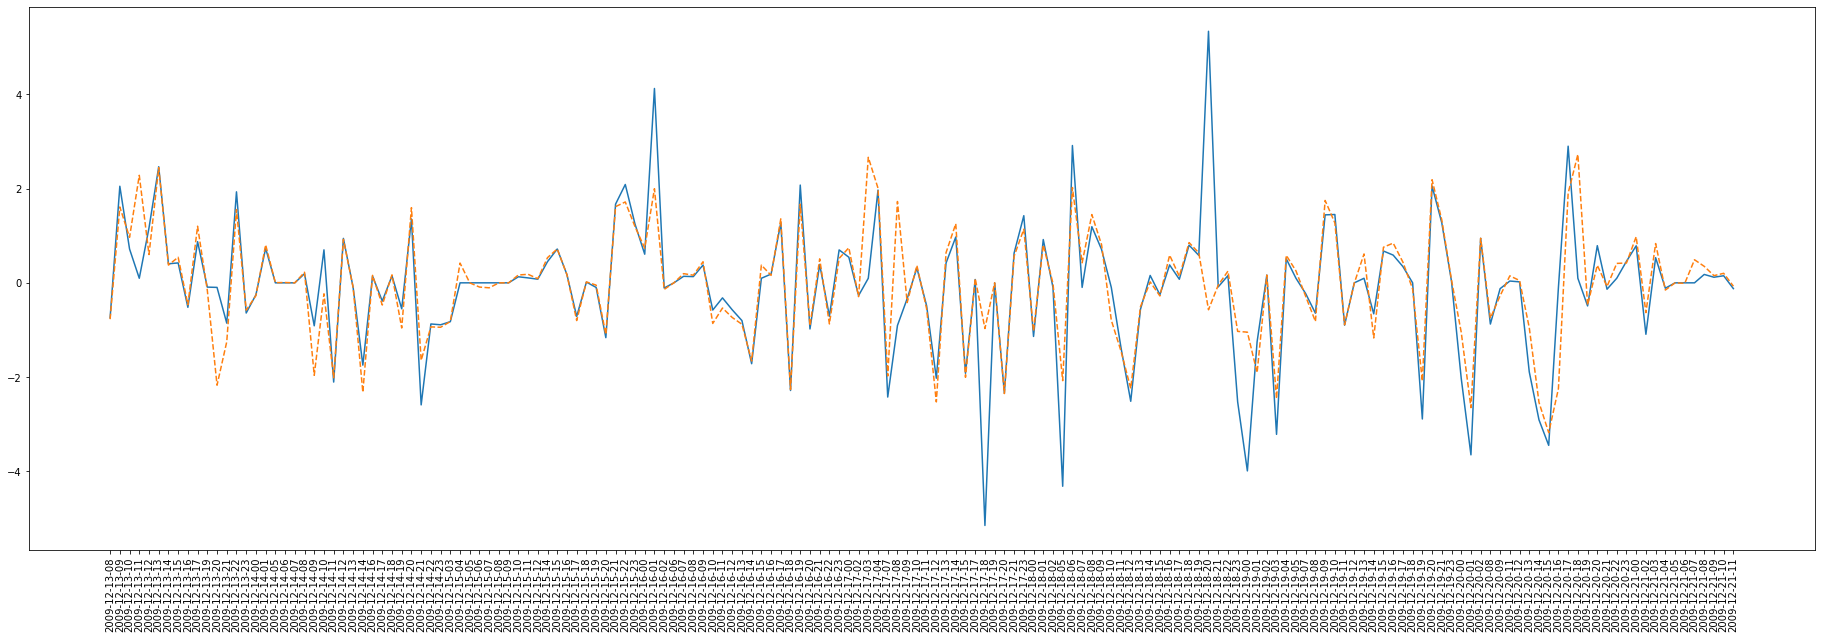

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(32, 10))

n = 24*7
plt.plot(y_test[0:n].index, y_test[0:n])
plt.plot(y_test[0:n].index, y_pred[0:n], linestyle='--')
plt.xticks(y_test.index[0:n],  rotation='vertical')

plt.show()

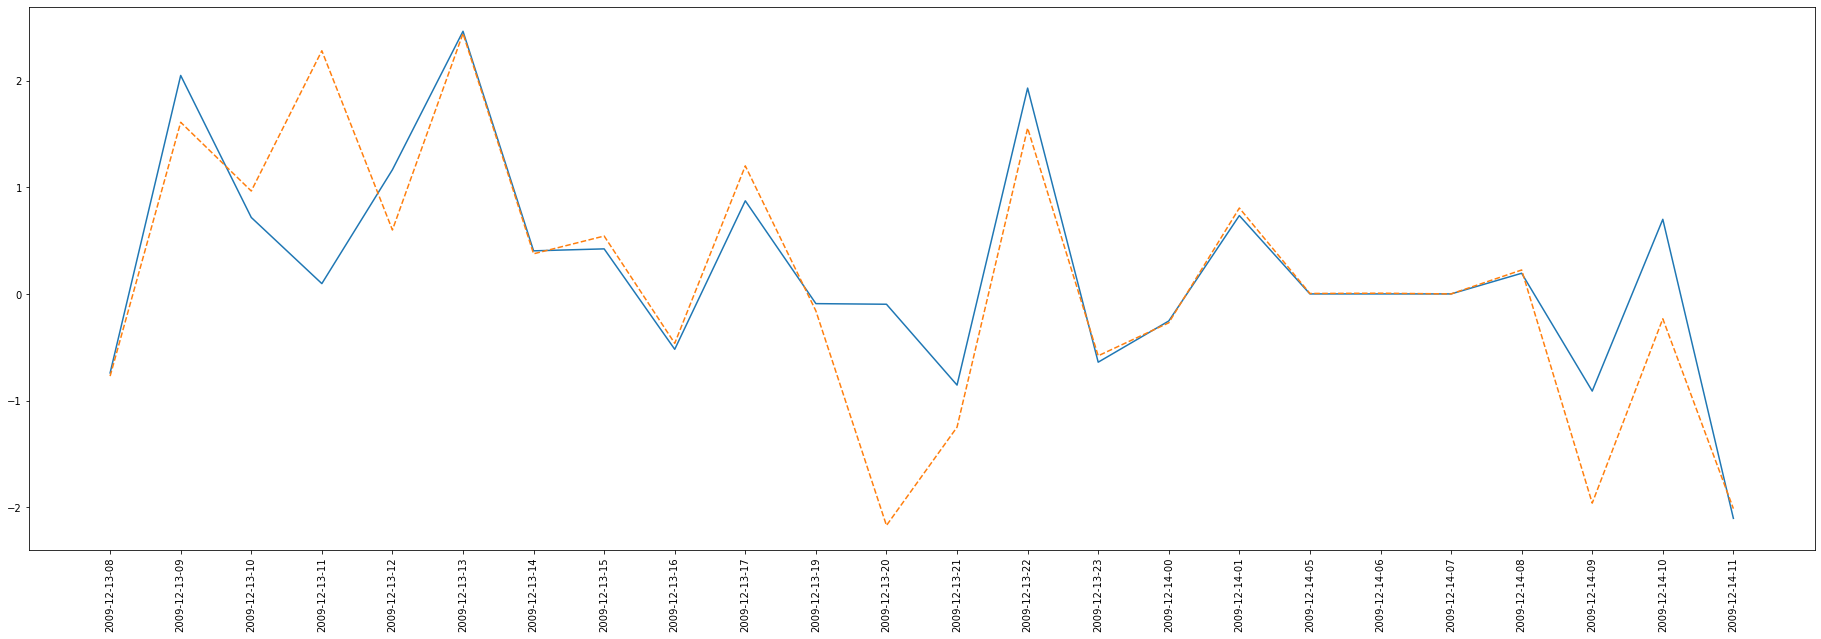

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(32, 10))

n = 24
plt.plot(y_test[0:n].index, y_test[0:n])
plt.plot(y_test[0:n].index, y_pred[0:n], linestyle='--')
plt.xticks(y_test.index[0:n],  rotation='vertical')

plt.show()